In [1]:
import pyedflib
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.signal import butter, filtfilt

In [9]:
class SignalFile:
    def __init__(self, file_path):
        self.file_path = file_path
        self.file_handle = None
        self.sample_frequency = None
        self.signals = []
        
    def load_signals(self):
        self.file_handle = pyedflib.EdfReader(self.file_path)
        num_signals = self.file_handle.signals_in_file
        
        for i in range(num_signals):
            signal_info = self.file_handle.getSignalHeader(i)
            signal_name = signal_info['label']
            signal_buffer = self.file_handle.readSignal(i)
            signal_fs = self.file_handle.getSampleFrequencies()[0]
            self.signals.append((signal_name, signal_buffer, signal_fs))

    def close(self):
        if self.file_handle is not None:
            self.file_handle.close()
            self.file_handle = None
            self.signals = []

def read_files_from_dir(directory: Path):
    extensions = ["edf", "bdf"]

    return [SignalFile(file.path) for file in os.scandir(directory) 
            if file.is_file() and file.name.endswith(tuple(extensions))]


In [14]:
directory = Path("data/edf/")
files = read_files_from_dir(directory)

for signal_file in files:
    signal_file.load_signals()

    # # Accessing signal data:
    # for signal_name, signal_buffer in signal_file.signals:
    #     print(f'Signal: {signal_name}')
    #     print(f'Buffer: {signal_buffer}')

    signal_file.close()

In [13]:
for file in files:
    file.close()

In [20]:
def apply_butterworth(signal, cutoff, fs, order=3, type='low'):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype=type, analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Usage example

signal = files[0].signals[2][1]
fs = files[0].file_handle.getSampleFrequencies()[0]
filtered_signal = apply_butterworth(signal, 15, fs, 3, 'low')

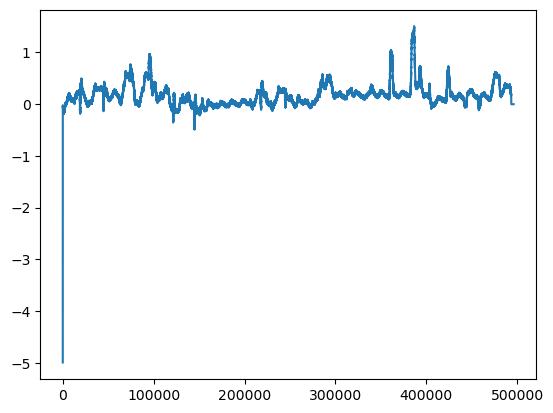

In [27]:
plt.plot(signal)

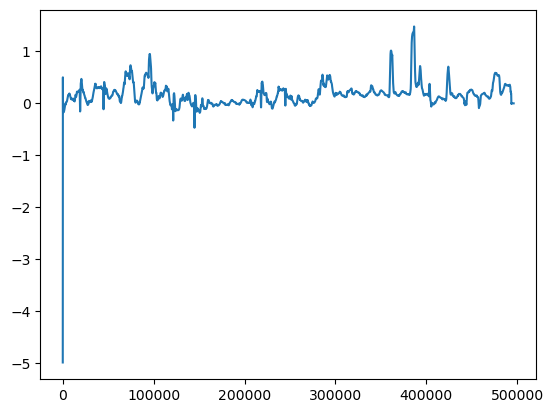

In [28]:
plt.plot(filtered_signal)

In [23]:
butterworth_lowpass = filter(lambda t: t[0].split()[0] in ['BI', 'Atmung/Respiration'], files[0].signals)

for label, signal, fs in butterworth_lowpass:
    filtered_signal = apply_butterworth(signal, 15, fs, 3, 'low')

In [25]:
butterworth_highpass = filter(lambda t: t[0].split()[0] in ['EMG'], files[0].signals)

for label, signal, fs in butterworth_lowpass:
    filtered_signal = apply_butterworth(signal, 15, fs, 3, 'high')